In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import concat, DataFrame
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score, roc_auc_score, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import LambdaCallback


In [2]:
# Convert series to supervised learning format
def series_to_supervised(data, n_in=5, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = [], []
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    agg = concat(cols, axis=1)
    agg.columns = names
    if dropnan:
        agg.dropna(inplace=True)
    return agg


In [3]:
# Load dataset
dataset = pd.read_csv('technical_indicators/BHP/Trough Detection/BHPTRU.csv',
                      header=0,index_col=0)

values = dataset.values.astype('float32')

# Normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

# Frame as supervised learning (7 timesteps input, forecasting next 2 timesteps)
n_in_steps = 7
n_out_steps = 2
reframed = series_to_supervised(scaled, n_in_steps, n_out_steps)

print(reframed.head())


    var1(t-7)  var2(t-7)  var3(t-7)  var4(t-7)  var5(t-7)  var6(t-7)  \
7    0.473464   0.399862   0.572502   0.505595   0.000000   0.270387   
8    0.480391   0.473464   0.399862   0.572502   0.136755   0.319360   
9    0.495793   0.480391   0.473464   0.399862   0.231230   0.370372   
10   0.591920   0.495793   0.480391   0.473464   0.112204   0.480676   
11   0.504141   0.591920   0.495793   0.480391   0.091429   0.333697   

    var7(t-7)  var8(t-7)  var9(t-7)  var10(t-7)  ...  var20(t+1)  var21(t+1)  \
7    0.251201   0.260576   0.349954    0.000000  ...    0.030320    0.292107   
8    0.301592   0.224096   0.307113    0.000000  ...    0.029384    0.336335   
9    0.339905   0.276756   0.277163    0.136755  ...    0.029384    0.353590   
10   0.429497   0.365488   0.375592    0.231230  ...    0.028448    0.261199   
11   0.430604   0.380006   0.392274    0.112204  ...    0.025753    0.287804   

    var22(t+1)  var23(t+1)  var24(t+1)  var25(t+1)  var26(t+1)  var27(t+1)  \
7     0.

In [4]:
values = reframed.values

train_size = 4199  
train = values[:train_size, :]
test = values[train_size:, :]

# Split into input and outputs (assuming last column is target)
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

# Reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

print(train_X.shape, train_y.shape)
print(test_X.shape, test_y.shape)


(4199, 1, 260) (4199,)
(1048, 1, 260) (1048,)


In [5]:
model = Sequential()
model.add(LSTM(64, return_sequences=True,
               input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(32, return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(32, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])


C:\Users\rithe\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [6]:
# Callback to print every 50 epochs only
print_callback = LambdaCallback(
    on_epoch_end=lambda epoch, logs: 
        print(f"Epoch {epoch+1}: loss={logs['loss']:.4f}, accuracy={logs['accuracy']:.4f}, val_loss={logs['val_loss']:.4f}, val_accuracy={logs['val_accuracy']:.4f}") 
        if (epoch+1) % 50 == 0 or epoch == 0 else None)

history = model.fit(train_X, train_y,
                    epochs=500,
                    batch_size=80,
                    validation_data=(test_X,test_y),
                    verbose=0,
                    shuffle=False,
                    callbacks=[print_callback])


Epoch 1: loss=0.6162, accuracy=0.7449, val_loss=0.5670, val_accuracy=0.7452
Epoch 50: loss=0.4461, accuracy=0.7471, val_loss=0.4299, val_accuracy=0.7452
Epoch 100: loss=0.4373, accuracy=0.7407, val_loss=0.4255, val_accuracy=0.7452
Epoch 150: loss=0.3799, accuracy=0.7652, val_loss=0.3865, val_accuracy=0.7586
Epoch 200: loss=0.3529, accuracy=0.7880, val_loss=0.3921, val_accuracy=0.7567
Epoch 250: loss=0.3733, accuracy=0.7814, val_loss=0.4495, val_accuracy=0.7452
Epoch 300: loss=0.3116, accuracy=0.8209, val_loss=0.3982, val_accuracy=0.7490
Epoch 350: loss=0.3176, accuracy=0.8295, val_loss=0.3962, val_accuracy=0.7519
Epoch 400: loss=0.2753, accuracy=0.8469, val_loss=0.4189, val_accuracy=0.7424
Epoch 450: loss=0.2725, accuracy=0.8564, val_loss=0.4413, val_accuracy=0.7452
Epoch 500: loss=0.3010, accuracy=0.8445, val_loss=0.5480, val_accuracy=0.7261


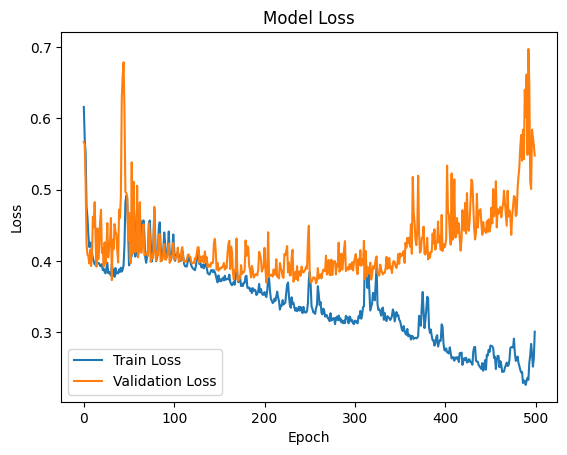

In [7]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()


In [8]:
# Make predictions on test set
yhat_probs = model.predict(test_X)
yhat_classes = (yhat_probs > 0.5).astype("int32")

# Evaluate predictions with classification metrics
accuracy = accuracy_score(test_y,yhat_classes)
precision = precision_score(test_y,yhat_classes)
recall = recall_score(test_y,yhat_classes)
f1 = f1_score(test_y,yhat_classes)
kappa = cohen_kappa_score(test_y,yhat_classes)
auc = roc_auc_score(test_y,yhat_probs)
matrix= confusion_matrix(test_y,yhat_classes)

print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'Cohen\'s Kappa: {kappa:.4f}')
print(f'ROC AUC: {auc:.4f}')
print('Confusion Matrix:')
print(matrix)


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
Accuracy: 0.7261
Precision: 0.3387
Recall: 0.0787
F1 Score: 0.1277
Cohen's Kappa: 0.0350
ROC AUC: 0.7853
Confusion Matrix:
[[740  41]
 [246  21]]


In [9]:
n_future=20

forecast_input=reframed.values[-n_future:, :-1]
forecast_input=forecast_input.reshape((forecast_input.shape[0], 1 ,forecast_input.shape[1]))

forecast=model.predict(forecast_input)
forecast_classes=(forecast>0.5).astype("int32")

dummy=np.zeros((forecast.shape[0], scaled.shape[1]))
dummy[:,0]=forecast.flatten() # assuming target is first column

inv_forecast=scaler.inverse_transform(dummy)[:,0]

print("\nForecasted Values (Inverse Transformed):")
print(inv_forecast)

print("\nForecasted Classes (Binary Predictions):")
print(forecast_classes.flatten())


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step

Forecasted Values (Inverse Transformed):
[-0.18813355 -0.18810561 -0.18535519 -0.16906311 -0.12926165 -0.18813355
 -0.16668623 -0.18813355 -0.17640256 -0.11553321 -0.18813355 -0.1824565
 -0.14615848 -0.18640647 -0.1197257   0.07217037 -0.18813355 -0.15244435
 -0.18813355 -0.18643146]

Forecasted Classes (Binary Predictions):
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]
